# Chains in LangChain

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# %pip install pandas

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [3]:
import pandas as pd
df = pd.read_csv('Data.csv')

In [4]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\r\n,I loved this product. But they only seem to l...


## LLMChain

In [ ]:
from langchain_ollama import OllamaLLM
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [19]:
llm = OllamaLLM(model="phi3:mini",temperature=0.9)

prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

chain = prompt | llm

product = "Queen Size Sheet Set"
chain.invoke(product)

'A suitable and fitting business name for a company specializing in producing high-quality queen size sheet sets could be "Majestic Mattresses & Linens". This title gives an immediate association with comfort, luxury, and quality bedding which are important selling points of the product. It hints at premium offerings that go beyond just mattresses as suggested by \'mattresses\' in their name - encompassing all related products like pillows, comforters etc., thereby broadening appeal to potential customers who may want a holistic bedding solution from one source or provider. The word "Majestic" could denote the high-end quality of these mattresses and linens in customer\'thy perceptions, fostering an image of grandeur related not just with sleep but also lifestyle comfort. Furthermore, it is catchy enough to be memorable which helps in brand recognition when customers recall a specific product or shop for their bedding needs online.'

## SimpleSequentialChain

In [12]:
from langchain.chains import SimpleSequentialChain

llm = OllamaLLM(model="phi3:mini")

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)


In [13]:

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [14]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [ ]:
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
A suitable and catchy name for a bedding manufacturing business specializing in queen-size sheet sets could be "Luxe Linens." This name suggests high quality, comfort, and style while reflecting the product's nature as premium bed linen. The term 'luxe' evokes an image of luxury and indulgence that aligns with superior products for enhancing sleep experiences at home or in hotels. It is simple to remember yet distinctive enough to stand out from generic names found on typical household goods websites, making it more appealing both as a product identifier and potential brand name.
"Luxe Linens: Elevate your nights with queen-size sheet sets designed for unparalleled comfort."

> Finished chain.
"Luxe Linens: Elevate your nights with queen-size sheet sets designed for unparalleled comfort."


## SequentialChain

In [20]:
from langchain.chains import SequentialChain

llm = OllamaLLM(model="phi3:3.8b", temperature=0.9)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )

In [21]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [23]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [24]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [25]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [27]:
review = df.Review[5]
overall_chain.invoke(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\r\nVieux lot ou contrefaçon !?",
 'English_Review': "I find the taste mediocre. The foam doesn't hold, that's strange. I buy them at retail stores and the flavor is much better... \r\nOld stock or counterfeit!?",
 'summary': 'A customer finds a latte unappealing in terms of taste and texture while noting superior quality when purchased from retail stores, raising suspicion of either old-stock inconsistency or possible fakes.',
 'followup_message': 'Réponse: Vous avez mentionné une fois de plus que le goût d\'un latte que vous aviez acheté récemment était médiocre, la mousse ne tient pas. Cela signifie-t-il que l\'on trouve des produits qui sont soit vieux stocks, soit faux ? Votre observation est intéressante et mérite une enquête approfondie pour garantir le bon niveau de qualité à chaque client. Merci d\'avoir partagé votre expérience !\n\

## Router Chain

In [ ]:
from langchain.chains.router.multi_prompt import MultiPromptChain

llm = OllamaLLM(model="phi3:3.8b")

prompt_1_template = """
You are an expert on animals. Please answer the below query:

{input}
"""

prompt_2_template = """
You are an expert on vegetables. Please answer the below query:

{input}
"""

prompt_infos = [
    {
        "name": "animals",
        "description": "prompt for an animal expert",
        "prompt_template": prompt_1_template,
    },
    {
        "name": "vegetables",
        "description": "prompt for a vegetable expert",
        "prompt_template": prompt_2_template,
    },
]

chain = MultiPromptChain.from_prompts(llm, prompt_infos)

d:\software\python3104\lib\site-packages\pydantic\main.py:253: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [57]:
chain.invoke({"input": "What color are carrots?"})

{'input': 'What color are carrots?',
 'text': "Carrots are typically orange in color, although they can also be found in purple (known as Purple Top), yellow (sometimes referred to as Yellowstone or gold varieties), white, and red. The most common orange-fleshed variety is 'Nantes,' which has been widely cultivated due to its flavor and ability to keep for longer periods of time compared to other colors."}

## Router Chain (no DeprecationWraning more)

Generated By Gemini 

In [62]:
# Updated Imports
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, RunnableBranch
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage

llm = OllamaLLM(model="phi3:3.8b")

# Define the PromptTemplates as a dictionary for easier management
prompt_templates = {
    "animals": PromptTemplate.from_template("You are an expert on animals. Please answer the below query:\n\n{input}"),
    "vegetables": PromptTemplate.from_template("You are an expert on vegetables. Please answer the below query:\n\n{input}"),
}

# Define the destination chains
destination_chains = {
    name: prompt | llm | StrOutputParser()
    for name, prompt in prompt_templates.items()
}

print(destination_chains)

{'animals': PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='You are an expert on animals. Please answer the below query:\n\n{input}')
| OllamaLLM(model='phi3:3.8b')
| StrOutputParser(), 'vegetables': PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='You are an expert on vegetables. Please answer the below query:\n\n{input}')
| OllamaLLM(model='phi3:3.8b')
| StrOutputParser()}


In [63]:
# Define a default chain for when the router can't find a match
default_chain = PromptTemplate.from_template("I am sorry, I cannot answer questions about that topic. Please ask about animals or vegetables.\n\n{input}") | llm | StrOutputParser()

# The routing logic now becomes a core part of the chain itself.
router_template = """
Given a user query, determine the most relevant category.
You can choose from these options:
- animals
- vegetables
- default

Please output the category name ONLY. Do not add any extra text, newlines, or explanations.
"""
router_prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content=router_template),
    ("human", "{input}"),
])

# Create the router chain to determine the category
router_chain = router_prompt | llm | StrOutputParser()

# Construct the routing branch. This is the key to fixing your issue.
# The RunnableBranch will check the output of the router chain and then
# route the original input to the correct destination chain.
branch_chain = RunnableBranch(
    (
        RunnableLambda(lambda x: "animals" in router_chain.invoke(x).lower()),
        destination_chains["animals"]
    ),
    (
        RunnableLambda(lambda x: "vegetables" in router_chain.invoke(x).lower()),
        destination_chains["vegetables"]
    ),
    default_chain
)

# Now, we combine the input with the router to create the final, executable chain.
# The RunnablePassthrough is used to pass the original input through the chain.
final_chain = {"input": RunnablePassthrough()} | branch_chain

# Example usage:
response = final_chain.invoke({"input": "What is a Lion?"})
print(response, '\n')

response = final_chain.invoke({"input": "What is a potato?"})
print(response)

A lion (Panthera leo) is one of the largest living members of the cat family, native to Africa and parts of India. It' endowed with its distinctive physical characteristics such as a muscular build, deep chest, broad head, tufted ears, short rounded tail, and most notably for males, an imposing mane that grows around their heads during certain seasons due to hormonal changes in response to environmental factors.

Lions are social animals living primarily within large family units called prides which consist of related females (often sisters from a common litter), their cubs and subordinate males, although smaller groups or even solitary males have been observed occasionally.  The pride territory may cover several square miles where they hunt for food mainly comprising medium-to-large sized ungulates such as zebras, wildebeest, antelopes, etc., employing a strategy that often involves the female lions hunting in groups while males guard their domain.

Despite being known to be aggressiv

## LangGraph

[python.langchain.com](https://python.langchain.com/docs/versions/migrating_chains/multi_prompt_chain/)

In [ ]:
# %pip install -qU langgraph

In [ ]:
from typing import Literal

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_ollama import ChatOllama
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict

# LLM
llm = ChatOllama(model="phi3:mini")

# Define the prompts
prompt_1 = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert on animals."),
        ("human", "{input}"),
    ]
)
prompt_2 = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert on vegetables."),
        ("human", "{input}"),
    ]
)
prompt_default = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert on all knowledges."),
        ("human", "{input}"),
    ]
)

# Construct the chains
chain_1 = prompt_1 | llm | StrOutputParser()
chain_2 = prompt_2 | llm | StrOutputParser()
chain_default = prompt_default | llm | StrOutputParser()

# Routing system
route_system = "Route the user's query to either the animal or vegetable expert. If none applies, fallback to default."
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", route_system),
        ("human", "{input}"),
    ]
)

# Define schema for routing output
class RouteQuery(TypedDict):
    """Route query to destination expert."""
    destination: Literal["animal", "vegetable", "default"]

route_chain = route_prompt | llm.with_structured_output(RouteQuery)

# State for LangGraph
class State(TypedDict):
    query: str
    destination: str   # always "animal" | "vegetable" | "default"
    answer: str

# Route query node
async def route_query(state: State, config: RunnableConfig):
    destination = await route_chain.ainvoke(state["query"], config)
    return {"destination": destination["destination"]}

# Answer nodes
async def prompt_1(state: State, config: RunnableConfig):
    return {"answer": await chain_1.ainvoke(state["query"], config)}

async def prompt_2(state: State, config: RunnableConfig):
    return {"answer": await chain_2.ainvoke(state["query"], config)}

async def prompt_default(state: State, config: RunnableConfig):
    return {"answer": await chain_default.ainvoke(state["query"], config)}

# Conditional routing: map destination -> node
def select_node(state: dict) -> Literal["prompt_1", "prompt_2", "prompt_default"]:
    mapping = {
        "animal": "prompt_1",
        "vegetable": "prompt_2",
        "default": "prompt_default",
    }
    return mapping.get(state.get("destination"), "prompt_default")

# Build graph
graph = StateGraph(State)
graph.add_node("route_query", route_query)
graph.add_node("prompt_1", prompt_1)
graph.add_node("prompt_2", prompt_2)
graph.add_node("prompt_default", prompt_default)

graph.add_edge(START, "route_query")
graph.add_conditional_edges("route_query", select_node)
graph.add_edge("prompt_1", END)
graph.add_edge("prompt_2", END)
graph.add_edge("prompt_default", END)

app = graph.compile()


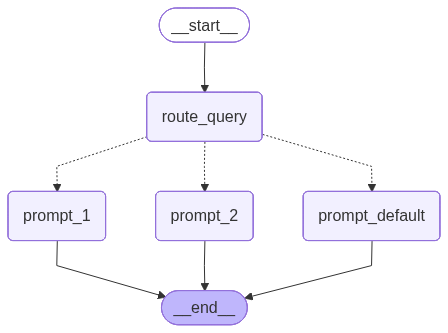

In [12]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [13]:
state = await app.ainvoke({"query": "what color are carrots"})
print(state["destination"])
print(state["answer"])


vegetable
Carrots are generally orange in color, although they can also be found in purple (known as blackstrap), white (such as the Chantenay or Norway variety), and yellow varieties. The common sweet flavor of these crunchy roots comes from beta-carotene, which is an orange pigment that our bodies convert into vitamin A.


In [17]:
state = await app.ainvoke({"query": "what color are dogs"})
print(state["destination"])
print(state["answer"])


animal
Dogs come in a variety of colors, and their coat can range from black to white with many different shades such as gray, brown, yellow, red, and even multicolored patterns like brindle or piebald (black and white). So while no single color represents all dogs due to the vast diversity among breeds, it's safe to say that you can find almost any color in the dog world.


In [14]:
state = await app.ainvoke({"query": "what is 2 + 2"})
print(state["destination"])
print(state["answer"])


default
The sum of 2 and 2 is 4. This simple arithmetic operation follows the basic principles of addition where combining two sets of objects results in a total count that equals to the aggregate amount; thus, when we add up these particular integers, their combined value amounts to four units (whether they are being counted as numbers or physical items).
